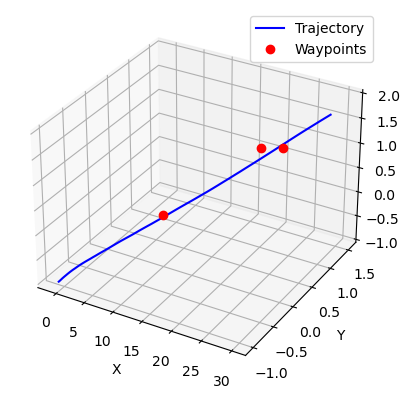

In [15]:
import numpy as np

class Mover:
    def __init__(self, m, F, dt, theta, sigma, waypoints, p0, v0):
        """
        Initialize the mover.

        Parameters:
        - m (float): Mass of the mover.
        - F (float): Constant thrust magnitude.
        - dt (float): Time step.
        - theta (float): Turn constraint half-angle (radians).
        - sigma (float): Standard deviation of noise force.
        - waypoints (np.ndarray): Array of waypoints [(x1,y1,z1), ...].
        - p0 (np.ndarray): Initial position [x0, y0, z0].
        - v0 (np.ndarray): Initial velocity [vx0, vy0, vz0].
        """
        self.m = m
        self.F = F
        self.dt = dt
        self.theta = theta
        self.sigma = sigma
        self.waypoints = waypoints
        self.p = p0.copy()
        self.v = v0.copy()
        self.current_waypoint_idx = 0

    def update(self):
        """Update the mover’s state. Returns False if all waypoints reached."""
        if self.current_waypoint_idx >= len(self.waypoints):
            return False

        waypoint = self.waypoints[self.current_waypoint_idx]
        d = waypoint - self.p
        distance = np.linalg.norm(d)
        waypoint_threshold = 3

        if distance < waypoint_threshold:
            self.current_waypoint_idx += 1
            if self.current_waypoint_idx >= len(self.waypoints):
                return False
            waypoint = self.waypoints[self.current_waypoint_idx]
            d = waypoint - self.p
            distance = np.linalg.norm(d)

        # Desired direction
        d_unit = d / distance

        # Compute thrust direction
        v_norm = np.linalg.norm(self.v)
        if v_norm > 0:
            v_unit = self.v / v_norm
            # Test desired thrust
            v_test = self.v + (self.F / self.m) * self.dt * d_unit
            v_test_norm = np.linalg.norm(v_test)
            if v_test_norm > 0:
                cos_phi = np.dot(self.v, v_test) / (v_norm * v_test_norm)
                cos_phi = np.clip(cos_phi, -1, 1)  # Avoid numerical errors
                phi = np.arccos(cos_phi)
            else:
                phi = np.pi  # Max angle if v_test is zero

            if phi <= self.theta:
                u = d_unit
            else:
                # Direction perpendicular to v toward d
                w = d_unit - (np.dot(d_unit, v_unit)) * v_unit
                w_norm = np.linalg.norm(w)
                if w_norm > 0:
                    w_unit = w / w_norm
                    # Rotate v_unit by theta toward d_unit
                    u = np.cos(self.theta) * v_unit + np.sin(self.theta) * w_unit
                else:
                    u = v_unit  # Aligned, maintain direction
        else:
            u = d_unit  # If at rest, thrust toward waypoint

        # Apply forces
        F_thrust = self.F * u
        F_noise = np.random.normal(0, self.sigma, 3)
        F_total = F_thrust + F_noise

        # Update state
        a = F_total / self.m
        self.v += a * self.dt
        self.p += self.v * self.dt

        return True

    def simulate(self, max_steps=1000):
        """Run simulation until waypoints are reached or max_steps exceeded."""
        trajectory = [self.p.copy()]
        for _ in range(max_steps):
            if not self.update():
                break
            trajectory.append(self.p.copy())
        return np.array(trajectory)

# Example usage
def run_simulation():
    m = 1.0
    F = 1.0
    dt = 0.1
    theta = np.pi / 6  # 30 degrees
    sigma = 0.1
    waypoints = np.array([[10.0, 0, 0], [20, 1, 1], [30, 0, 2]])
    p0 = np.array([-1.0, -1, -1])
    v0 = np.array([0.0, 0, 0])

    mover = Mover(m, F, dt, theta, sigma, waypoints, p0, v0)
    trajectory = mover.simulate()

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'b-', label='Trajectory')
    ax.plot(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], 'ro', label='Waypoints')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

if __name__ == "__main__":
    run_simulation()